# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
#use this cell to import additional libraries or define helper functions
from sklearn.metrics import mean_squared_error

## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [3]:
#Load your data into a pandas dataframe here
df = pd.read_csv("module2_data.csv")

In [4]:
#convert datetime to epoch/unix time
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['unix'] = df['Datetime'].astype('int64') // 10**9

In [5]:
df.head()

,Datetime,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,unix
0,2006-12-16 17:24:00,2006-12-16,17:24:00,4.21600,0.41800,234.84000,18.40000,0.00000,1.00000,17.00000,1166289840
1,2006-12-16 17:25:00,2006-12-16,17:25:00,5.36000,0.43600,233.63000,23.00000,0.00000,1.00000,16.00000,1166289900
2,2006-12-16 17:26:00,2006-12-16,17:26:00,5.37400,0.49800,233.29000,23.00000,0.00000,2.00000,17.00000,1166289960
3,2006-12-16 17:27:00,2006-12-16,17:27:00,5.38800,0.50200,233.74000,23.00000,0.00000,1.00000,17.00000,1166290020
4,2006-12-16 17:28:00,2006-12-16,17:28:00,3.66600,0.52800,235.68000,15.80000,0.00000,1.00000,17.00000,1166290080


## Predicting Global Active Power

We will follow the code from the Chapter 9 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A: ph is Prediction Horizon, and mu is Forgetting Factor. ph refers to the number of time steps into the future for which we want to make predictions. For example, if my data is in minutes and ph is 60, this means we are trying to predict the GAP 60 minutes into the future. The forgetting factor determines how much weight is given to older data versus more recent data. A forgetting factor closer to 1 means that older observations are given nearly as much weight as newer observations, while a forgetting factor closer to 0 means that more recent observations are given much more weight, and we forget older observations.

**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [6]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes
ph_index = 5 #ph/data resolution (how many timesteps is our ph?)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A: The first data point will have no influence on the last prediction in our dataset. To calculate the weight, you can use the formula weight=μ^(n−i). This would be 0.9^(5000-1), which is essentialy 0.

**TODO: Following the code from Chapter 10 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [7]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[ph_index-1:ph_index-1+i]
    ns = len(ys_tmp)

    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)

    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0] + ph
    yp = m_tmp*tp + q_tmp

    tp_pred[i-2] = tp
    yp_pred[i-2] = yp

Now let's visualize the results from our model.

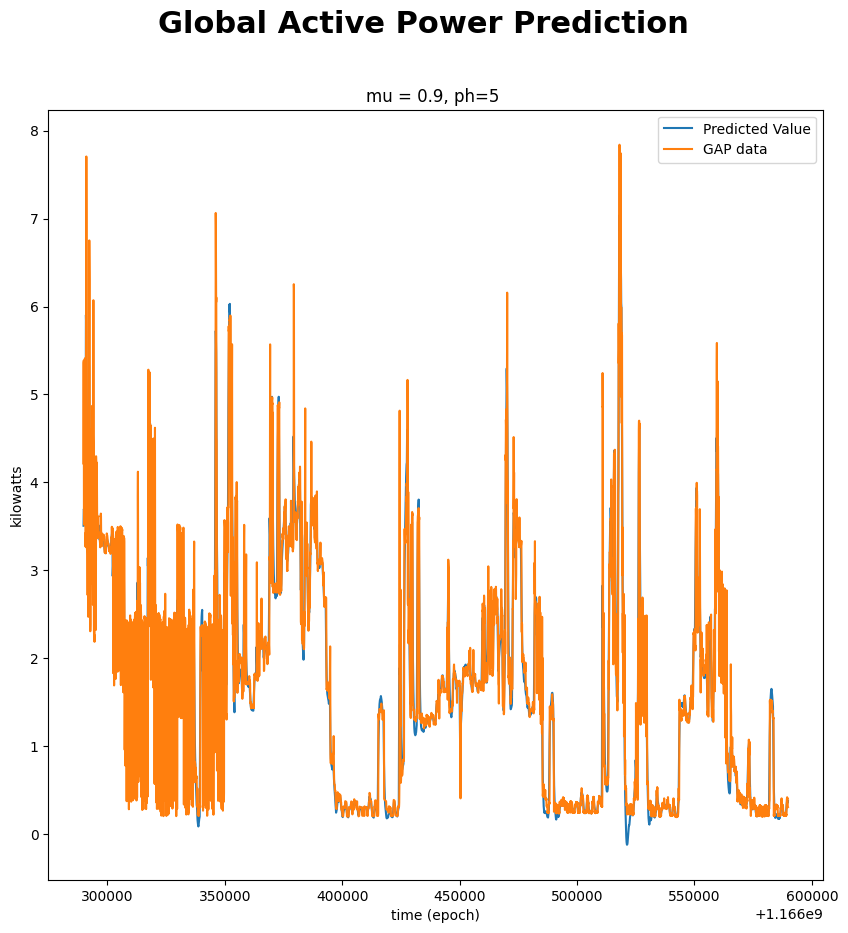

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value')
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

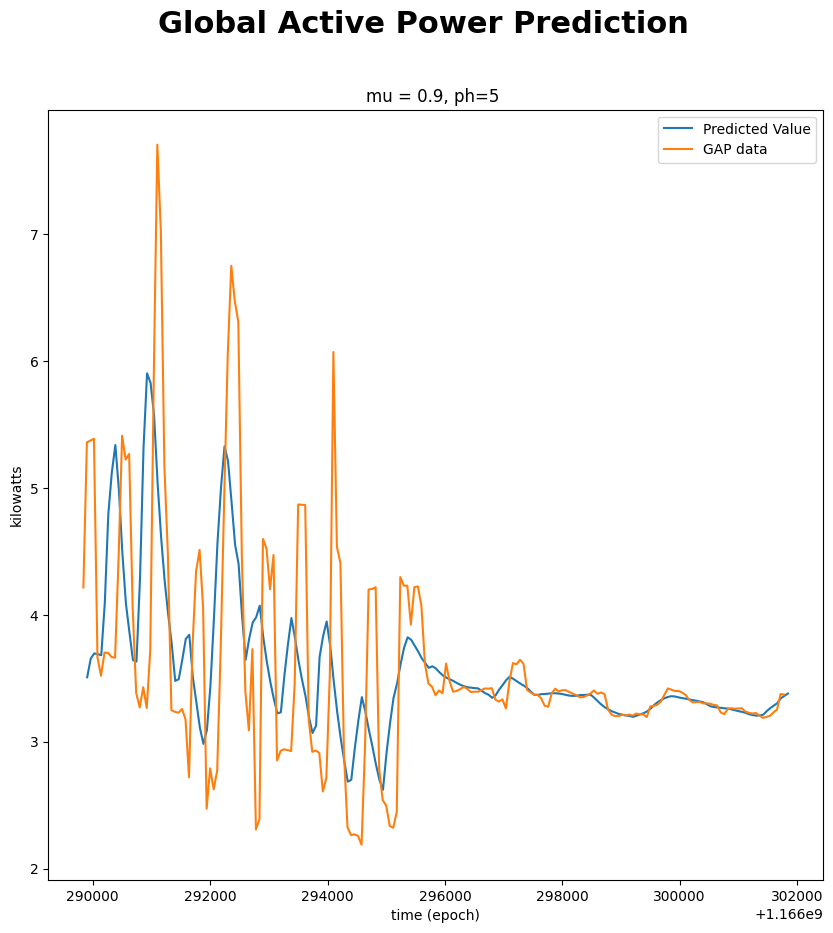

In [9]:
#Plot first 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

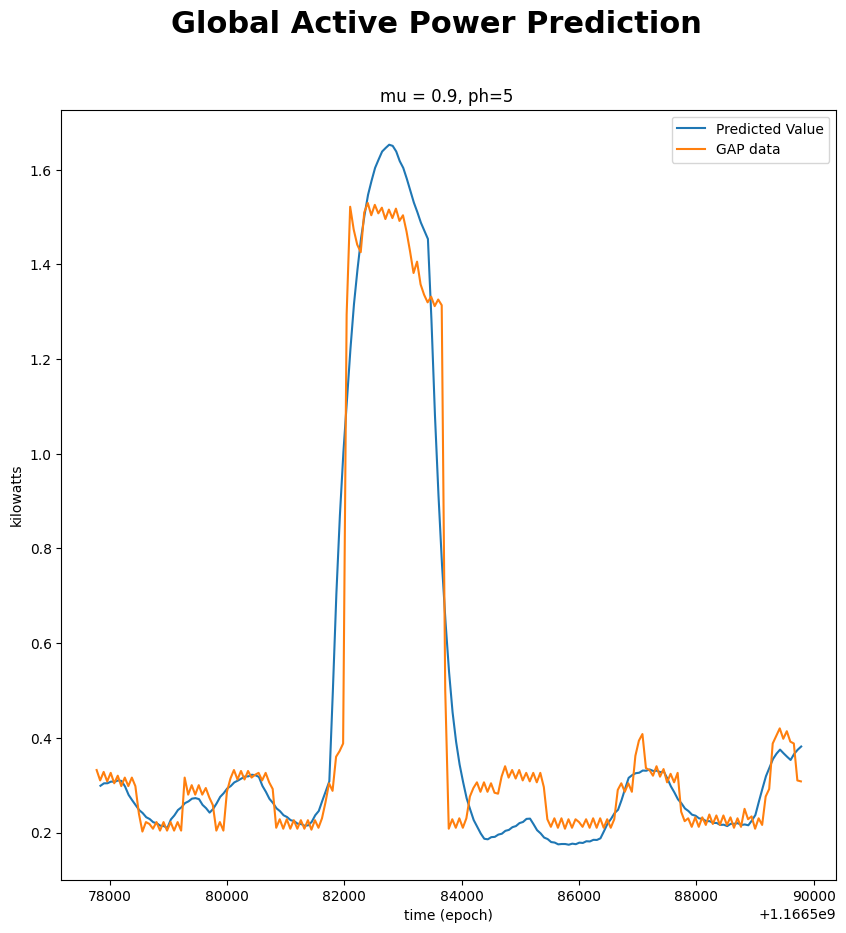

In [10]:
#Plot last 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))

# Calculate the starting index to plot the last 200 points
start = max(0, len(tp_pred) - 200)  # Ensures the index is not negative

ax.plot(tp_pred[start:], yp_pred[start:], label='Predicted Value')
ax.plot(ts.iloc[start:n_s,0], ys.iloc[start:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

In [11]:
#Calculate MSE of predictions
print("MSE is", mean_squared_error(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 0.22768235730576183


** *italicized text*Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The model seems to be performing reasonably well based on the charts and the MSE. On the first chart, I notice there is a higher range for the GAP data, and the model doesn't necessarily reach the peaks or valleys. In contrast, for the second chart, the range is lower, and sometimes, the predicted value overestimates the peaks and valleys. For both charts, the predicted values closely track the same pattern as the actual values. The MSE represents the averaged square difference between the predicted and actual vaues. Since the range for actual values is 0 to 8, an MSE of 0.227 suggests that the model is doing a relatively good job predicting Global Active Power.

**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

In [12]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes
ph_index = 5 #ph/data resolution (how many timesteps is our ph?)
mu = 1

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[ph_index-1:ph_index-1+i]
    ns = len(ys_tmp)


    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)

    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0] + ph
    yp = m_tmp*tp + q_tmp

    tp_pred[i-2] = tp
    yp_pred[i-2] = yp

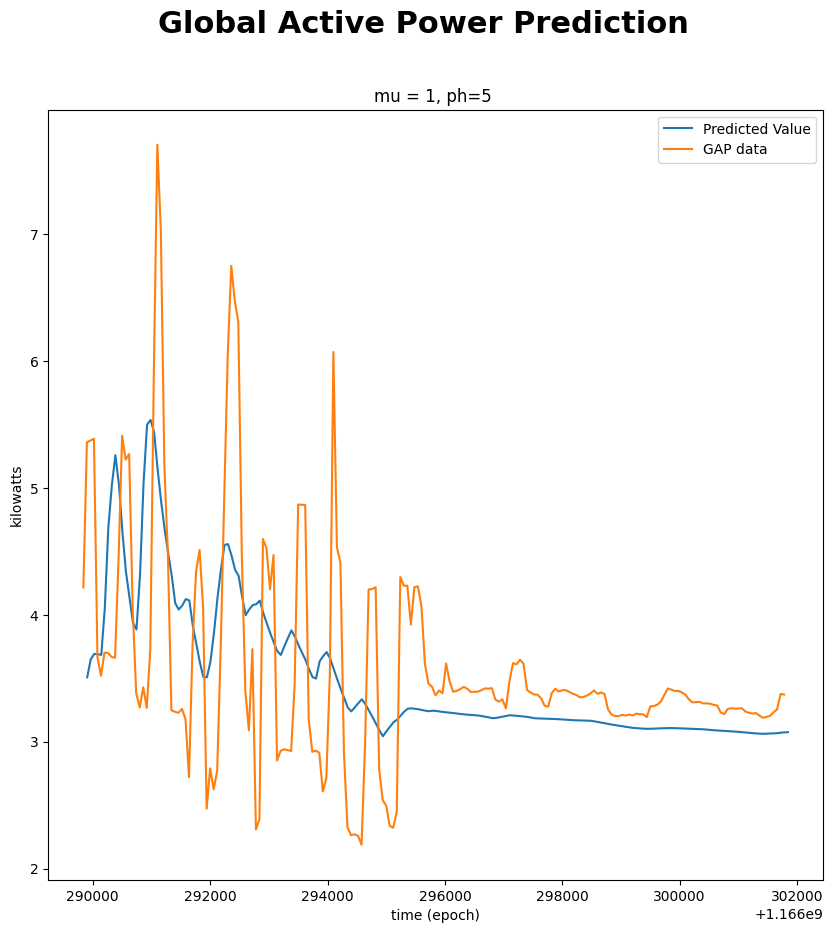

In [13]:
#Plot first 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

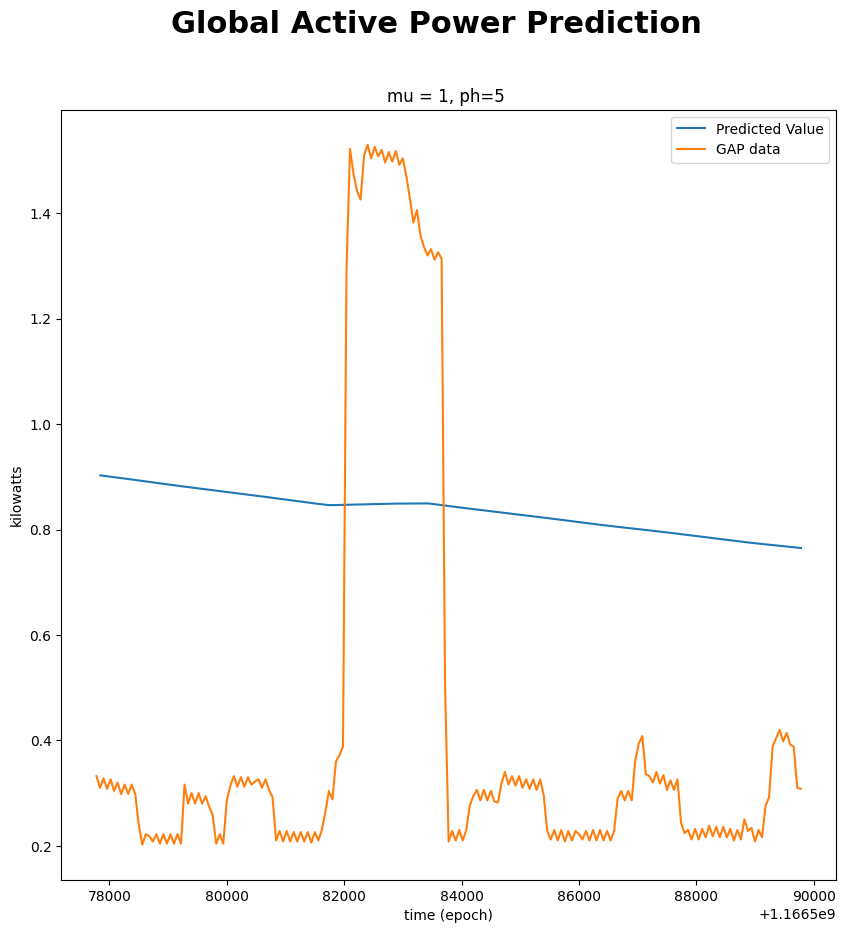

In [14]:
#Plot last 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
start = max(0, len(tp_pred) - 200)
ax.plot(tp_pred[start:], yp_pred[start:], label='Predicted Value')
ax.plot(ts.iloc[start:n_s,0], ys.iloc[start:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

In [15]:
#Calculate MSE of predictions for mu = 1
print("MSE is", mean_squared_error(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 1.3798739283418633


In [16]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes
ph_index = 5 #ph/data resolution (how many timesteps is our ph?)
mu = 0.01

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[ph_index-1:ph_index-1+i]
    ns = len(ys_tmp)


    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)

    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0] + ph
    yp = m_tmp*tp + q_tmp

    tp_pred[i-2] = tp
    yp_pred[i-2] = yp

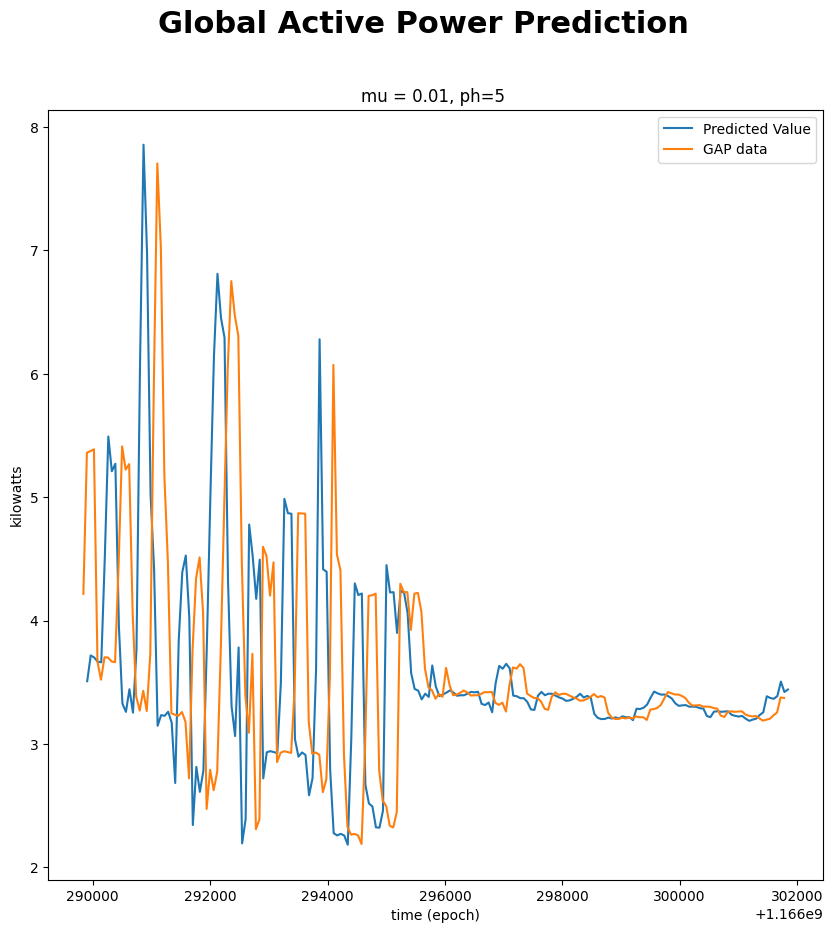

In [17]:
#Plot first 200 data points/predictions for mu = 0.01
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

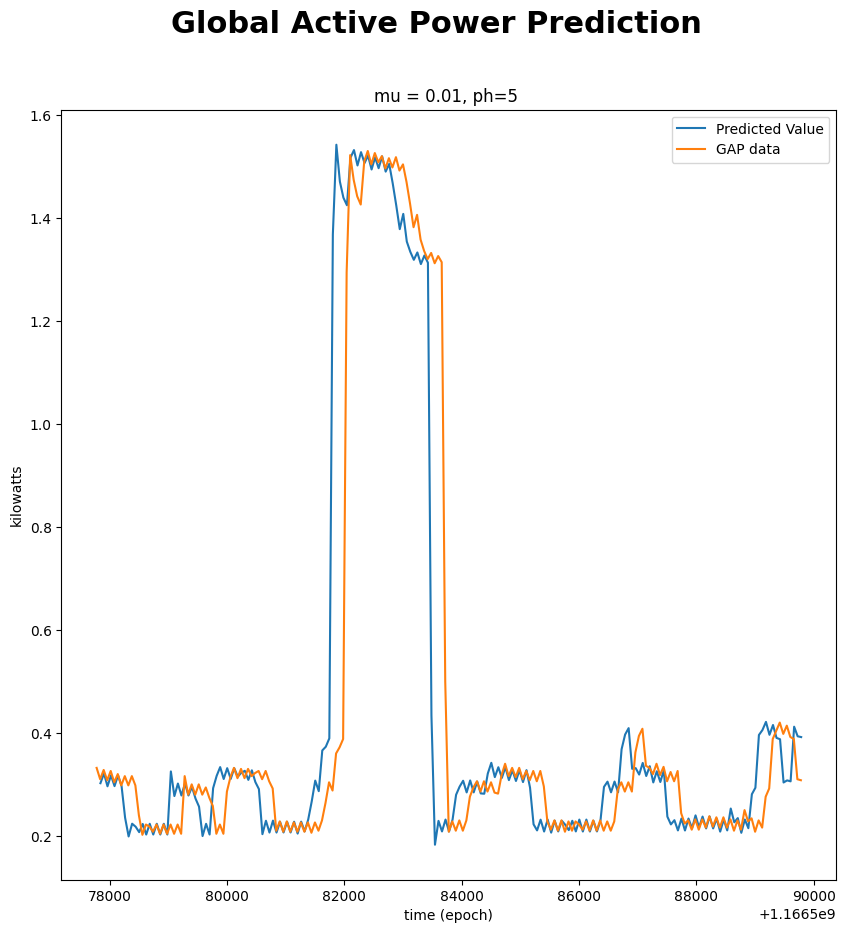

In [18]:
#Plot last 200 data points/predictions for mu = 0.01
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
start = max(0, len(tp_pred) - 200)
ax.plot(tp_pred[start:], yp_pred[start:], label='Predicted Value')
ax.plot(ts.iloc[start:n_s,0], ys.iloc[start:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

In [19]:
#Calculate MSE of predictions for mu = 0.01
print("MSE is", mean_squared_error(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 0.0016549849242751755


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The mu = 1 model performed worse. On the first graph, you can see that the predicted values are starting to stabilize, meaning they track the actual values less and less. The pattern is slowly becoming more of a straight line. Then, in the second graph for the last 200 points, it is clearer that the predicted values now just represent the average over time. The pattern is very similar to a straight line. This makes sense since with a mu = 1, the forgetting factor is effecitvely turned off, so all data points are equally weighted. The MSE is now 1.3798739283418633, so it is clear that the predictions have gotten worse.

**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The mu = 1 model performed better although there seems to be a lag in the prediction, which probably equals the ph_index. The predicted value mirrors the actual value, but it is about 5 periods late. Since the mu is low, the model is very responsive to more recent data but does have a slight delay. There isn't too much of a difference between the early and late predictions. In the first half of the first chart, the predicted values don't reach the peaks and values, but then, it starts to become more accurate. The MSE is now 0.0016549849242751755, which tells me that the predictions have beomce more accurate.

**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A: Based on the charts and the MSE, the model with mu = 0.01 seems to be the best. This model has the lowest MSE at 0.0016549849242751755, indicating the highest accuracy. We can also see that it has the highest accuracy based on looking at the two charts. This makes sense because a mu = 1 treats all data equally while a mu = 0.01 puts more emphases on recent data. This enables the model to adapt to recent trends and be more responsive to changes in the data.

**Q: What could we do to improve our model and/or make it more realistic and useful?**

A: We could implement some feature engineering techniques. For example, we could add time features like taking into account the hour of the day, week or month. Generally, there are cyclical patterns to power usage. We could also use rolling window calculations to capture trends. Another option would be to use other models like non-linear ones like Random Forests or Gradient Boosting Machines. We could also focus on fine-tuning our model parameters using techniques like grid search. Another option would be to include external data that could impact GAP like weather conditions.

**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [20]:
#add voltage to the x-variables in our dataset
ts = pd.DataFrame({
    'unix': df['unix'],
    'Voltage': df['Voltage']
})
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes
ph_index = 5
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

In [21]:
#run the prediction code on your expanded dataset
#make sure to adjust your yp prediction to include the coefficients from time AND voltage
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[ph_index-1:ph_index-1+i]
    ns = len(ys_tmp)


    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)

    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_[0]
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i - 1] + [ph, 0]  # Add ph to time, 0 to voltage (no change in voltage)
    yp = np.dot(m_tmp, tp) + q_tmp  # Dot product of coefficients and predictors + intercept

    tp_pred[i-2] = tp[0]
    yp_pred[i-2] = yp

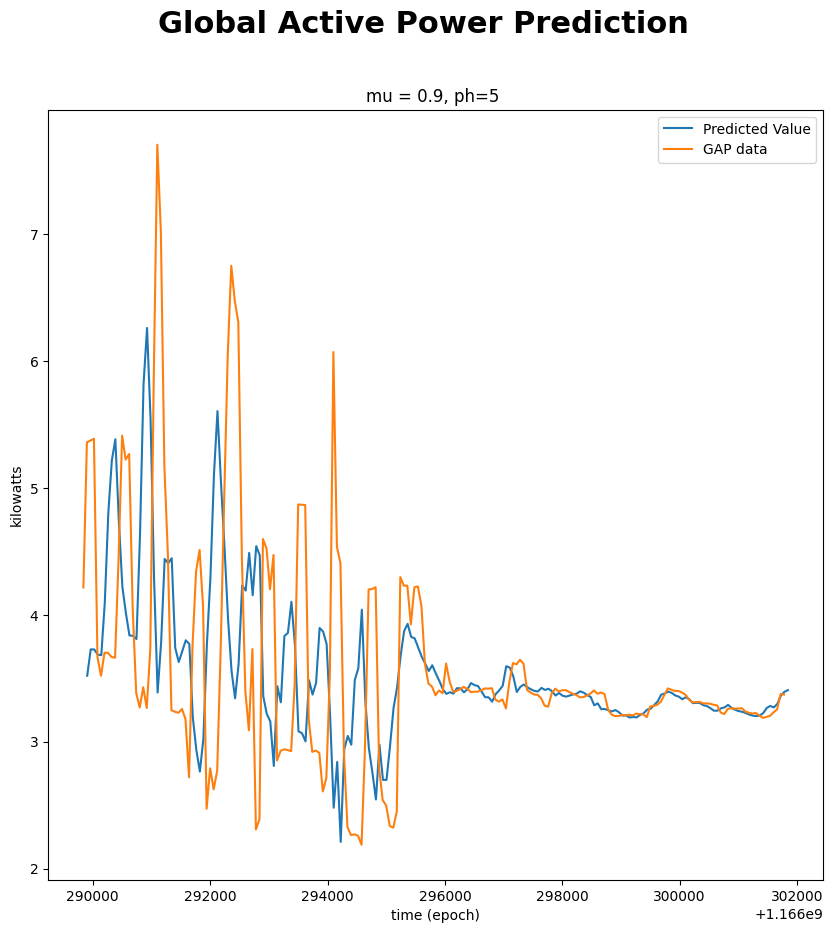

In [22]:
# Plot first 200 data points/predictions for the expanded dataset
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

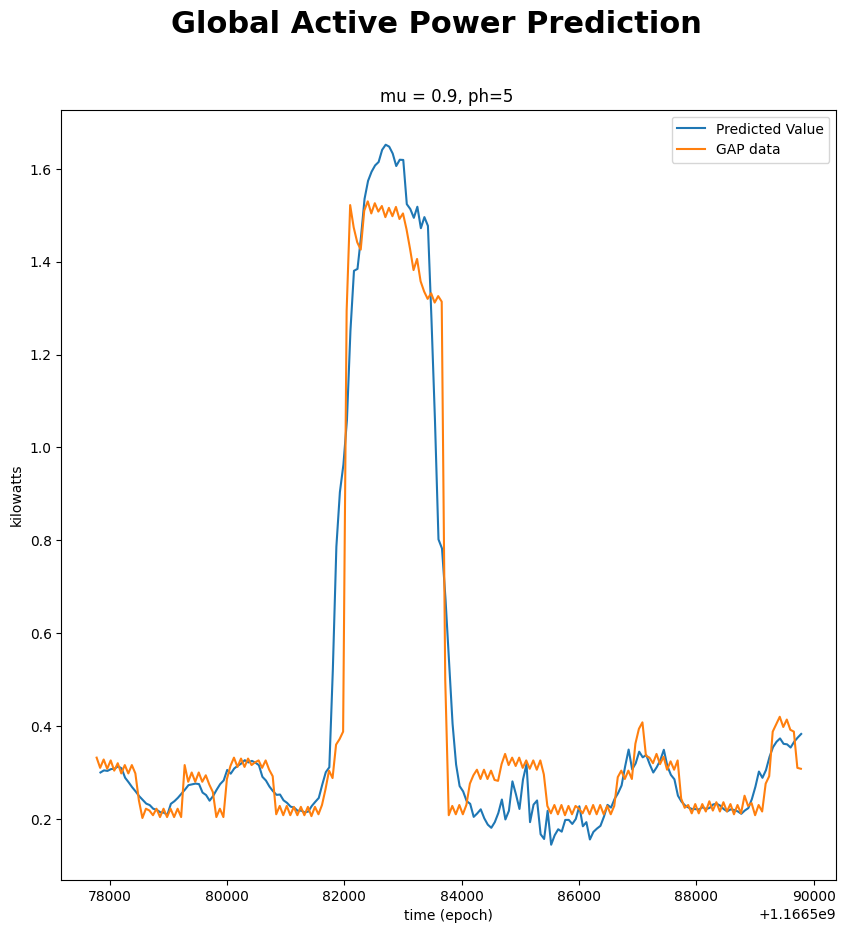

In [23]:
#Plot last 200 data points/predictions for the expanded data
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
start = max(0, len(tp_pred) - 200)
ax.plot(tp_pred[start:], yp_pred[start:], label='Predicted Value')
ax.plot(ts.iloc[start:n_s,0], ys.iloc[start:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

In [24]:
#Calculate MSE of predictions for the expanded data
print("MSE is", mean_squared_error(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 0.1821214527148013


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A: When adding voltage, the model had an MSE of 0.1821214527148013. This is better than the original model with the same mu = 0.9 which had an MSE of
0.22768235730576183. When comparing the two graphs, you can see that by adding the voltage data, the predicted values are less smooth and better approximate the actual values.


There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A: I chose an alternative model of using a moving window to limit the predictions instead of using a mu factor. This might improve the model because a moving window ensures the model only focuses on the most recent data points. This will help the model adapt more quickly to recent trends like seasonal changes. It also will help reduce noise from older datapoints.

In [25]:
#create your alternative training data here
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

window_size = 50
ph = 5
ph_index = 5

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
#you may need to adjust these
tp_pred = np.zeros(n_s - window_size)
yp_pred = np.zeros(n_s - window_size)

In [26]:
for i in range(window_size, n_s):
    # Get x and y data within the window for our prediction
    ts_tmp = ts.iloc[i - window_size:i]
    ys_tmp = ys.iloc[i - window_size:i]
    ns = len(ys_tmp)

    # All data points within the window are equally weighted
    weights = np.ones(ns)

    # Perform linear regression on data within the window
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    # Store model coefficients and intercept to compute prediction
    m_tmp = model_tmp.coef_[0]
    q_tmp = model_tmp.intercept_

    # Use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i - 1, 0] + ph
    yp = m_tmp * tp + q_tmp

    tp_pred[i - window_size] = tp
    yp_pred[i - window_size] = yp

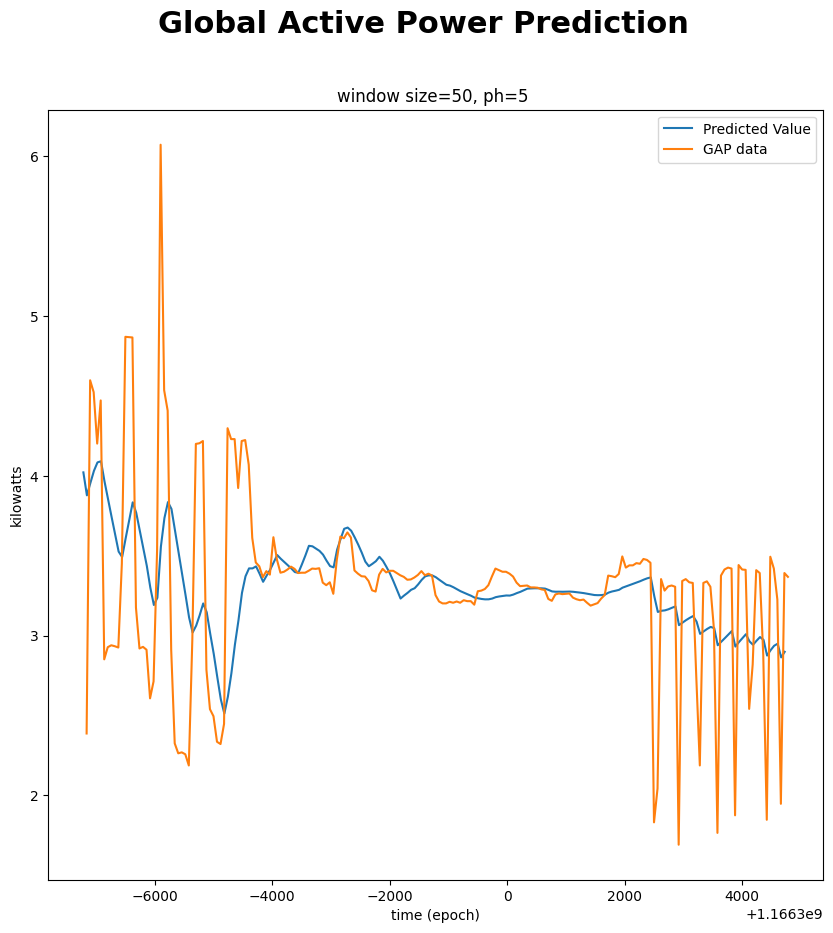

In [27]:
#Plot first 200 data points/predictions for alternative model
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('window size=%g, ph=%g ' %(window_size, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value')
ax.plot(ts.iloc[50:50+200,0], ys.iloc[50:50+200,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

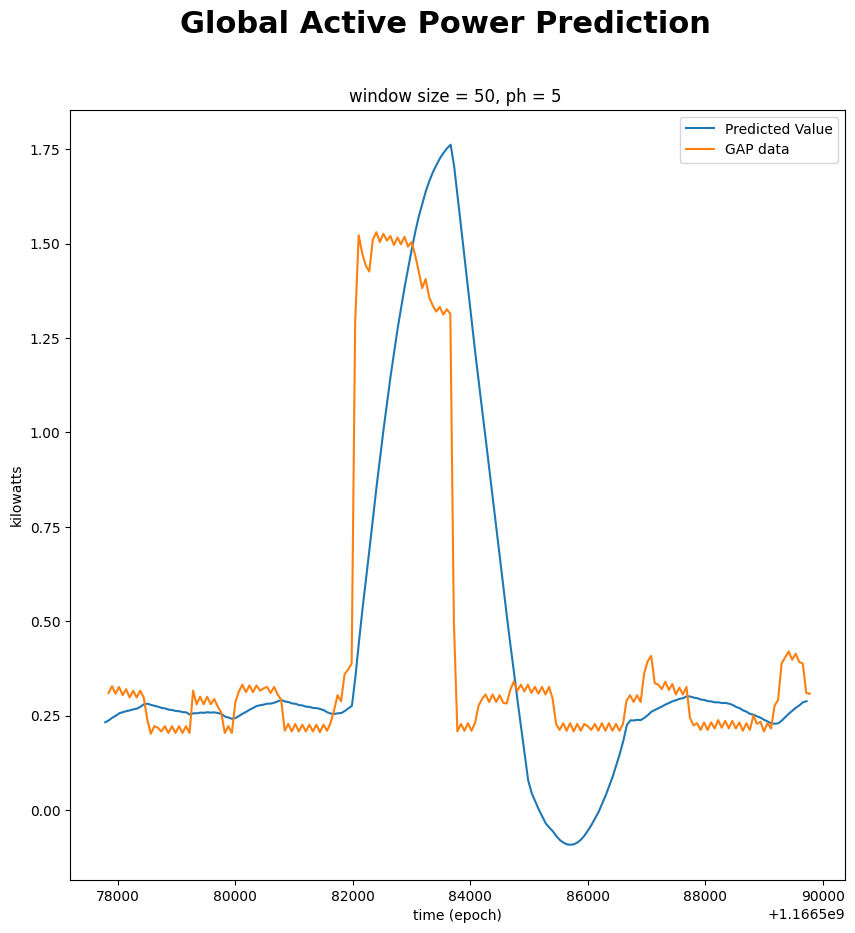

In [28]:
# Plotting the last 200 data points and predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('window size = %g, ph = %g ' % (window_size, ph))
start_pred = len(tp_pred) - 200
ax.plot(tp_pred[start_pred:start_pred + 200], yp_pred[start_pred:start_pred + 200], label='Predicted Value')
ax.plot(ts.iloc[start_pred+50:start_pred+50 + 200, 0], ys.iloc[start_pred+50:start_pred+50 + 200, 0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()
plt.show()

In [29]:
#Calculate MSE of predictions for alternative model
print("MSE is", mean_squared_error(ys['Global_active_power'][window_size:window_size+len(yp_pred)], yp_pred))

MSE is 0.5629289807323796


**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A: The alternative model didnn't improve on the previous results. It's MSE is 0.5629289807323796, so it performed worse than our initial models. To improve the model, we could try out different window sizes to find the optimal one that balances having enough historical data while still remaining responsive to recent trends. We could also implement suggestions mentioned earlier like feature engineering techniques and fine-tuning model parameters.

It's worth noting that the results we're getting in this assignment are based on a pretty short predictive horizon of 5 minutes. If we were to increase our predictive horizon, our results would likely be worse and there would be more room for optimizing and improving the predictions of our model.